`04_KPI.ipynb`
# ***KPI (Key Performance Indicator)***
> 핵심성과지표

## **`매트릭(Metric)`** 측정 가능한 모든 수치
- 방문자수, 클릭수, 매출액, 재고량
- 단순 측정값

## **`지표(Indicator)`** 의미가 부여된 매트릭
- 전월 대비 방문자 증가율, 클릭 전환률, 매출 성장률
- 비교 기준이 있고, 변화-방향성을 보여줌

## **`KPI`** 비즈니스 목표와 직결된 핵심 지표
- CAC (고객 확보 비용), LTV/CLV (고객 생애 가치), NPS (순추천고객지수)
- 전략적 의사결정에 직접 영향, 액션 가능한 인사이트 제공


## KPI가 비즈니스에 미치는 영향
    "1. 전략적 방향성 제시 KPI는 조직 전체가 같은 목표를 향해 나아갈 수 있도록 하는 나침반 역할을 합니다. 예를 들어, SaaS 기업에서 'Monthly Recurring Revenue(MRR)'를 주요 KPI로 설정하면, 마케팅팀은 신규 고객 획득에, 제품팀은 기능 개선을, CS팀은 고객 유지에 집중하게 됩니다.\n",
    "\n",
    "2. 데이터 기반 의사결정 문화 조성 \"감(感)\"이 아닌 \"팩트\"로 말하는 조직 문화를 만듭니다. 매주 월요일 아침, 임원진이 대시보드를 보며 \"지난주 CAC가 20% 증가했네요. 마케팅 채널별 효율성을 재검토해야겠습니다\"라고 말할 수 있게 되는 것입니다.\n",
    "\n",

## ***KPI 설계 원칙***
> - ***`S`pecific***    : 구체성
> - ***`M`easurable***  : 측정가능성
> - ***`A`chievable***  : 달성가능성
> - ***`R`elevent***    : 관련성
> - ***`T`ime-bound***  : 시한성

In [17]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings

warnings.filterwarnings('ignore', category=UserWarning)
plt.rcParams['font.family'] = 'Pretendard'
plt.rcParams['axes.unicode_minus'] = False
# 실습용 전자상거래 데이터 생성
np.random.seed(42)

# 고객 데이터 생성
customers = pd.DataFrame({
    'customer_id': range(1, 1001),
    'first_purchase_date': pd.date_range('2022-01-01', periods=1000, freq='D'),
    'acquisition_channel': np.random.choice(['organic', 'paid_search', 'social', 'email'], 1000, 
                                          p=[0.4, 0.3, 0.2, 0.1])
})

# 거래 데이터 생성 (더 현실적인 패턴)
transactions = []
for customer_id in range(1, 1001):
    first_date = customers[customers['customer_id'] == customer_id]['first_purchase_date'].iloc[0]
    
    # 고객별로 다른 구매 패턴 시뮬레이션
    purchase_frequency = np.random.exponential(30)  # 평균 30일마다 구매
    num_purchases = np.random.poisson(3) + 1  # 평균 3회 구매
    
    for i in range(num_purchases):
        purchase_date = first_date + timedelta(days=int(i * purchase_frequency))
        if purchase_date <= datetime(2024, 12, 31):
            transactions.append({
                'customer_id': customer_id,
                'purchase_date': purchase_date,
                'order_value': np.random.lognormal(4, 0.8),  # 로그정규분포로 현실적인 주문금액
                'order_id': len(transactions) + 1
            })

df = pd.DataFrame(transactions)
df['purchase_date'] = pd.to_datetime(df['purchase_date'])

print("데이터셋 개요")
print(f"총 고객 수: {len(customers):,}명")
print(f"총 거래 수: {len(df):,}건")
print(f"기간: {df['purchase_date'].min().date()} ~ {df['purchase_date'].max().date()}")

데이터셋 개요
총 고객 수: 1,000명
총 거래 수: 3,871건
기간: 2022-01-01 ~ 2024-12-28


In [5]:
df.head(20)

,customer_id,purchase_date,order_value,order_id
0,1,2022-01-01,16.099022,1
1,1,2022-01-07,52.126636,2
2,1,2022-01-13,105.086917,3
3,1,2022-01-19,60.768899,4
4,1,2022-01-25,78.047045,5
5,1,2022-01-31,46.034085,6
6,1,2022-02-06,134.727679,7
7,1,2022-02-12,51.196306,8
8,2,2022-01-02,17.740889,9
9,2,2022-02-26,81.518230,10


## RFM 분석
고객을 3가지 측면에서 바라보는 프리즘
>- #### ***`R`ecency***    `최근성` *얼마나 최근에 구매했는가?*
>- #### ***`F`requency***  `반복성` *얼마나 자주 구매했는가?*
>- #### ***`M`onetary***   `가치` *얼마나 많이 구매했는가?*

In [40]:
# RFM 분석을 위한 데이터 준비
def calculate_rfm(t_df: pd.DataFrame, analysis_date='2024-12-31') -> pd.DataFrame:
    """
    RFM 분석
    Recency: 활성도 측정. 최근 구매일. 낮을 수록 좋음
    Frequency: 충성도 측정. 구매 횟수. 높을 수록 좋음
    Monetary: 가치 측정. 총 구매 금액. 높을 수록 좋음
    """
    # rfm = df.groupby('customer_id').agg({
    #     'purchase_date': lambda x: (analysis_date - x.max()).days,
    #     'order_id': 'count',
    #     'order_value': 'sum'
    # }).reset_index()
    
    # rfm.columns = ['customer_id', 'recency', 'frequency', 'monetary']
    # return rfm
    analysis_date = pd.to_datetime(analysis_date)
    rfm = t_df.groupby('customer_id').agg({
        # Recency: 최근 구매일로부터의 일수
        'purchase_date': lambda x: (analysis_date - x.max()).days,
        # Frequency: 구매 횟수
        'order_id': 'count',
        # Monetary: 총 구매 금액
        'order_value': 'sum'
    }).reset_index()
    rfm.columns = ['customer_id', 'recency', 'frequency', 'monetary']
    # RFM 점수 계산
    rfm['r_score'] = pd.qcut(rfm['recency'], 5, labels=[5, 4, 3, 2, 1], duplicates='drop')
    # copilot이 제안한 코드가 잘못되어 수정
    rfm['f_score'] = pd.qcut(rfm['frequency'].rank(method='first'),5, labels=[1, 2, 3, 4, 5], duplicates='drop')
    rfm['m_score'] = pd.qcut(rfm['monetary'], 5, labels=[1, 2, 3, 4, 5], duplicates='drop')
    # RFM 점수 합산 # 그냥 더하기를 하면 안 되므로, string으로 변환 후 합산
    rfm['rfm_score'] = rfm['r_score'].astype(str) + rfm['f_score'].astype(str) + rfm['m_score'].astype(str)
    
    # RFM 등급 계산
    return rfm


rfm_data = calculate_rfm(df)


rfm_data.head(20)

# 고객 세그먼트 정의
def define_segments(rfm: pd.DataFrame) -> pd.DataFrame:
    """
    RFM 점수에 따라 고객 세그먼트 정의
    - R >= 4, F >= 4: VIP (매우 충성 고객)
    - R >= 3, F >= 3: Loyal Customers (충성 고객)
    - R >= 4, F <= 2: New Customers (신규 고객)
    - R <= 2, F >= 3: At Risk (위험 고객)
    - R <= 2, F <= 2: Lost Customers (이탈 고객)
    """
    def rfm_segment(row):
        if row['r_score'] >= 4 and row['f_score'] >= 4:
            return 'VIP'
        elif row['r_score'] >= 3 and row['f_score'] >= 3:
            return 'Loyal Customers'
        elif row['r_score'] >= 4 and row['f_score'] <= 2:
            return 'New Customers'
        elif row['r_score'] <= 2 and row['f_score'] >= 3:
            return 'At Risk'
        elif row['r_score'] <= 2 and row['f_score'] <= 2:
            return 'Lost Customers'
        else:
            return 'Other'

    rfm['segment'] = rfm.apply(rfm_segment, axis=1)
    return rfm

rfm_segments = define_segments(rfm_data)
rfm_segments.head(20)
# 세그먼트 만든 이유: 그룹화하여 분석하기 위함

,customer_id,recency,frequency,monetary,r_score,f_score,m_score,rfm_score,segment
0,1,1053,8,544.086589,1,5,5,155,At Risk
1,2,983,3,122.971850,1,1,1,111,Lost Customers
2,3,1055,2,325.510131,1,1,4,114,Lost Customers
3,4,1046,5,454.940546,1,4,5,145,At Risk
4,5,954,8,269.436813,1,5,3,153,At Risk
5,6,911,3,517.454613,1,1,5,115,Lost Customers
6,7,1068,2,232.878851,1,1,3,113,Lost Customers
7,8,1043,2,75.508594,1,1,1,111,Lost Customers
8,9,960,4,290.106234,1,3,3,133,At Risk
9,10,1081,3,369.658622,1,1,4,114,Lost Customers


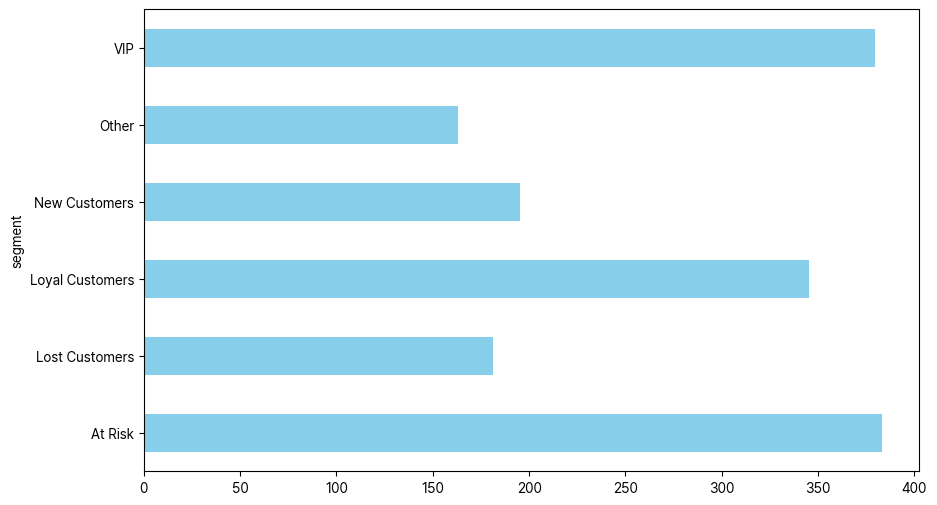

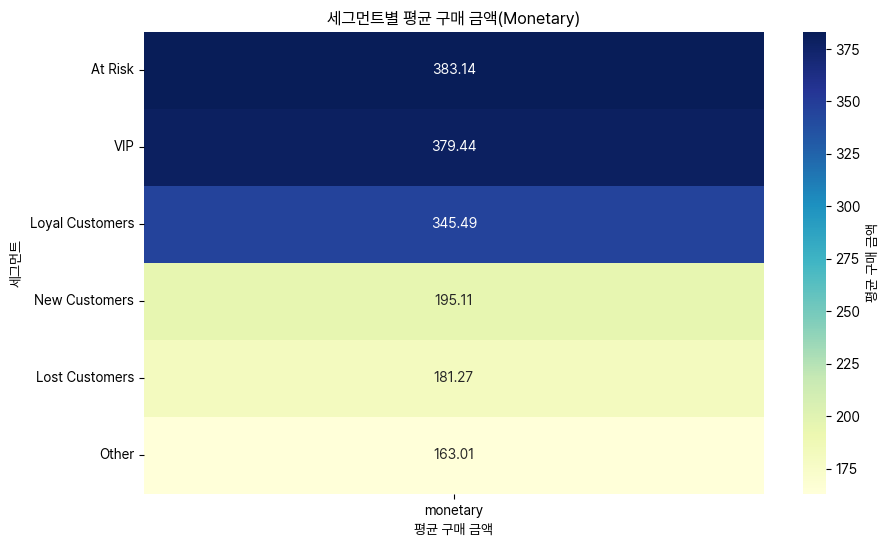

In [41]:
# Segments별로 데이터 그룹핑
segment_analysis = rfm_segments.groupby('segment').agg({
    'customer_id': 'count',
    'recency': ['mean', 'min', 'max'],  # 등급별 평균, 최소, 최대 Recency
    'frequency': ['mean', 'min', 'max'], # 등급별 평균, 최소, 최대 Frequency
    'monetary': ['mean', 'min', 'max'] # 등급별 평균, 최소, 최대 Monetary
}).round(2).reset_index().rename(columns={
    # 등급별 순서 맞추기
    'customer_id': '고객 수',
    'mean': '평균',
    'min': '최소',
    'max': '최대'
})
# 세그먼트 등급 순서대로 정렬
segment_order = ['VIP', 'Loyal Customers', 'New Customers', 'At Risk', 'Lost Customers', 'Other']
segment_analysis['segment'] = pd.Categorical(segment_analysis['segment'], categories=segment_order, ordered=True)
segment_analysis.sort_values('segment', inplace=True)
segment_analysis

# 세그먼트별 고객 수 및 비율 시각화
# 각 세그먼트(VIP, Loyal, New, At Risk, Lost 등)에 속한 고객 수와 전체 대비 비율을 막대그래프로 표시
# def plot_segment_distribution(rfm: pd.DataFrame):
#     segment_counts = rfm['segment'].value_counts()
#     plt.figure(figsize=(10, 6))
#     sns.barplot(x=segment_counts.index, y=segment_counts.values, palette='viridis')
#     plt.title('고객 세그먼트 분포')
#     plt.xlabel('세그먼트')
#     plt.ylabel('고객 수')
#     plt.xticks(rotation=45)
#     plt.show()
# plot_segment_distribution(rfm_segments)


# 세그먼트별 평균 구매 금액(Monetary) 비교
# 각 세그먼트의 평균 구매 금액을 비교하여, 어떤 그룹이 가장 높은 가치를 창출하는지 분석


# 세그먼트별 최근 구매일(Recency) 분포
# 각 세그먼트의 최근 구매일 분포를 박스플롯 등으로 시각화하여, 재구매 가능성 파악

# 세그먼트별 구매 빈도(Frequency) 분석
# 세그먼트별로 고객당 평균 구매 횟수를 비교하여 충성도 파악

# 세그먼트별 월별 매출 추이 분석
# 각 세그먼트의 월별 매출 변화를 시계열 그래프로 그려, 특정 그룹의 성장/이탈 트렌드 파악

# 세그먼트별 평균 구매 금액(Monetary) 히트맵 시각화
def plot_segment_monetary_heatmap(rfm: pd.DataFrame):
    """
    세그먼트별 평균 구매 금액(Monetary) 히트맵 시각화
    """
    pd.pivot_table(rfm, 
                   index='segment',
                   values='monetary',
                   aggfunc='mean').reset_index().set_index('segment').plot(kind='barh', 
                                                                        legend=False,
                                                                        color='skyblue',
                                                                        figsize=(10, 6))
    segment_monetary = rfm.groupby('segment')['monetary'].mean().reset_index()
    segment_monetary = segment_monetary.set_index('segment').sort_values(by='monetary', ascending=False)
    plt.figure(figsize=(10, 6))
    
    sns.heatmap(segment_monetary, annot=True, fmt='.2f', cmap='YlGnBu', cbar_kws={'label': '평균 구매 금액'})
    plt.title('세그먼트별 평균 구매 금액(Monetary)')
    plt.xlabel('평균 구매 금액')
    plt.ylabel('세그먼트')
    plt.show()
plot_segment_monetary_heatmap(rfm_segments)

In [54]:
# 고객 생애 가치(Customer Lifetime Value, CLV) 계산
def calculate_clv(t_df: pd.DataFrame):
    """
    고객 생애 가치(CLV) 계산
    CLV = (평균 구매 금액) * (평균 구매 빈도) * (평균 고객 생애 기간)
    해석:
    - CLV > CAC(고객획득비용): 수익성이 있는 고객
    - CLV / CAC 비율이 3:1 이상이면 수익성이 높다고 판단
    """
    
    # 1. 평균 구매 금액(Monetary)
    avg_order_value = t_df.groupby('customer_id')['order_value'].mean()
    
    # 2. 평균 구매 빈도(Frequency)
    def calculate_frequency(x):
        # 1회 구매자
        if len(x) <= 1:
            return 1
        # 2회 이상 구매자
        return len(x) / ((x['purchase_date'].max() - x['purchase_date'].min()).days + 1) * 365  # 연간 구매 빈도
    # 함수를 쓰지 말고 같은 내용을 람다 식으로 써보자.
    # avg_frequency = t_df.groupby('customer_id').apply(lambda x: len(x) / ((x['purchase_date'].max() - x['purchase_date'].min()).days + 1) * 365)

    purchase_frequency = t_df.groupby('customer_id').apply(calculate_frequency)
    # print(purchase_frequency) # 확인용
    
    # 3. 평균 고객 생존 기간(Lifetime)
    # 계산: 고객의 첫 구매일과 마지막 구매일 사이의 일수
    lifespan_days = t_df.groupby('customer_id').apply(
        lambda x: (x['purchase_date'].max() - x['purchase_date'].min()).days + 1
    )
    # print(lifespan_days) # 확인용

    # CLV 계산
    clv_data = pd.DataFrame({
        'customer_id': avg_order_value.index,
        'avg_order_value': avg_order_value.values,
        'avg_frequency': purchase_frequency.values,
        'lifespan_days': lifespan_days.values
    })

    clv_data['clv'] = clv_data['avg_order_value'] * clv_data['avg_frequency'] * (clv_data['lifespan_days'] / 365)
    return clv_data

clv_df = calculate_clv(df)

clv_df.head(20)

/var/folders/tx/t7px7cn503bgk6zlg3m0b4740000gn/T/ipykernel_97563/1140057201.py:24: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  purchase_frequency = t_df.groupby('customer_id').apply(calculate_frequency)
/var/folders/tx/t7px7cn503bgk6zlg3m0b4740000gn/T/ipykernel_97563/1140057201.py:29: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  lifespan_days = t_df.groupby('customer_id').apply(


,customer_id,avg_order_value,avg_frequency,lifespan_days,clv
0,1,68.010824,67.906977,43,544.086589
1,2,40.990617,9.776786,112,122.971850
2,3,162.755066,18.717949,39,325.510131
3,4,90.988109,38.829787,47,454.940546
4,5,33.679602,21.159420,138,269.436813
5,6,172.484871,6.083333,180,517.454613
6,7,116.439425,33.181818,22,232.878851
7,8,37.754297,15.869565,46,75.508594
8,9,72.526558,11.406250,128,290.106234
9,10,123.219541,182.500000,6,369.658622


평균 CLV: 290.89 $
중앙값 CLV: 264.77 $
상위 10% CLV: 526.87 $


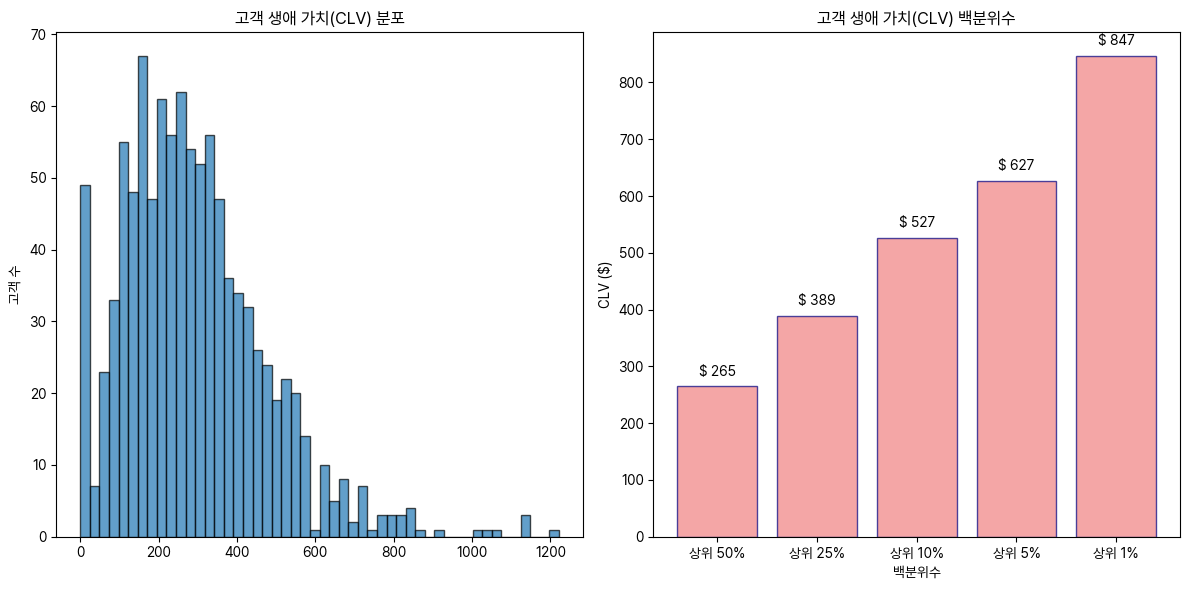

In [86]:
# 시각화
print(f'평균 CLV: {clv_df["clv"].mean():,.2f} $')
print(f'중앙값 CLV: {clv_df["clv"].median():,.2f} $')
print(f'상위 10% CLV: {clv_df["clv"].quantile(0.9):,.2f} $') # quantile을 쓴다는 건, 이미 정렬이 되어 있다는 뜻
print('=' * 50)

plt.figure(figsize=(12, 6))

# CLV 분포 히스토그램
plt.subplot(1, 2, 1)
plt.hist(clv_df['clv'], bins=50, alpha=0.7, edgecolor='black')
plt.title('고객 생애 가치(CLV) 분포')
plt.ylabel('고객 수')

# CLV 상위 50, 75, 90, 95, 99 백분위수
plt.subplot(1, 2, 2)
# ver.copilot
# clv_percentiles = clv_df['clv'].quantile([0.5, 0.75, 0.9, 0.95, 0.99])
# clv_percentiles.plot(kind='bar', color='skyblue')

# ver. 쌤
clv_percentiles = [50, 75, 90, 95, 99]
clv_values = [clv_df['clv'].quantile(p/100) for p in clv_percentiles]
plt.bar(range(len(clv_percentiles)), clv_values, color='lightcoral', alpha=0.7, edgecolor='navy')
plt.xticks(range(len(clv_percentiles)), [f'상위 {100-p}%' for p in clv_percentiles])
plt.title('고객 생애 가치(CLV) 백분위수')
plt.ylabel('CLV ($)')
plt.xlabel('백분위수')

# CLV 값 레이블 추가
for idx, value in enumerate(clv_values):
    plt.text(idx, value + 0.01 * max(clv_values) + 5, f'$ {value:.0f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

In [103]:
# 위의 데이터로 파레토 법칙 검증

# clv 내림차순 정렬
clv_sorted = clv_df.sort_values('clv', ascending=False).reset_index(drop=True)
# 누적 CLV 및 백분율 계산
clv_sorted['cumulative_clv'] = clv_sorted['clv'].cumsum()
# 해당 고객까지의 누적 CLV 비율
clv_sorted['cumulative_pct'] = clv_sorted['cumulative_clv'] / clv_sorted['cumulative_clv'].max() * 100
# 모든 고객 옆 상위 몇 %인지 계산
clv_sorted['customer_pct'] = (clv_sorted.index + 1) / len(clv_sorted) * 100

# df에서 상위 20% 고객의 누적 CLV 비중 중 가장 큰 값
upper_20p = clv_sorted[clv_sorted['customer_pct'] <= 20]

top20rev = upper_20p['cumulative_pct'].iloc[-1]

print(f'상위 20% 고객의 누적 CLV 비중: {top20rev:.2f}%')

상위 20% 고객의 누적 CLV 비중: 39.26%


## 코호트(Cohort) 분석
- 공통된 특성 / 경험을 가진 집단
- 특정 시점이나 조건을 기준으로 고객 집단을 추적
- 시간에 따라 행동 패턴의 변화를 분석

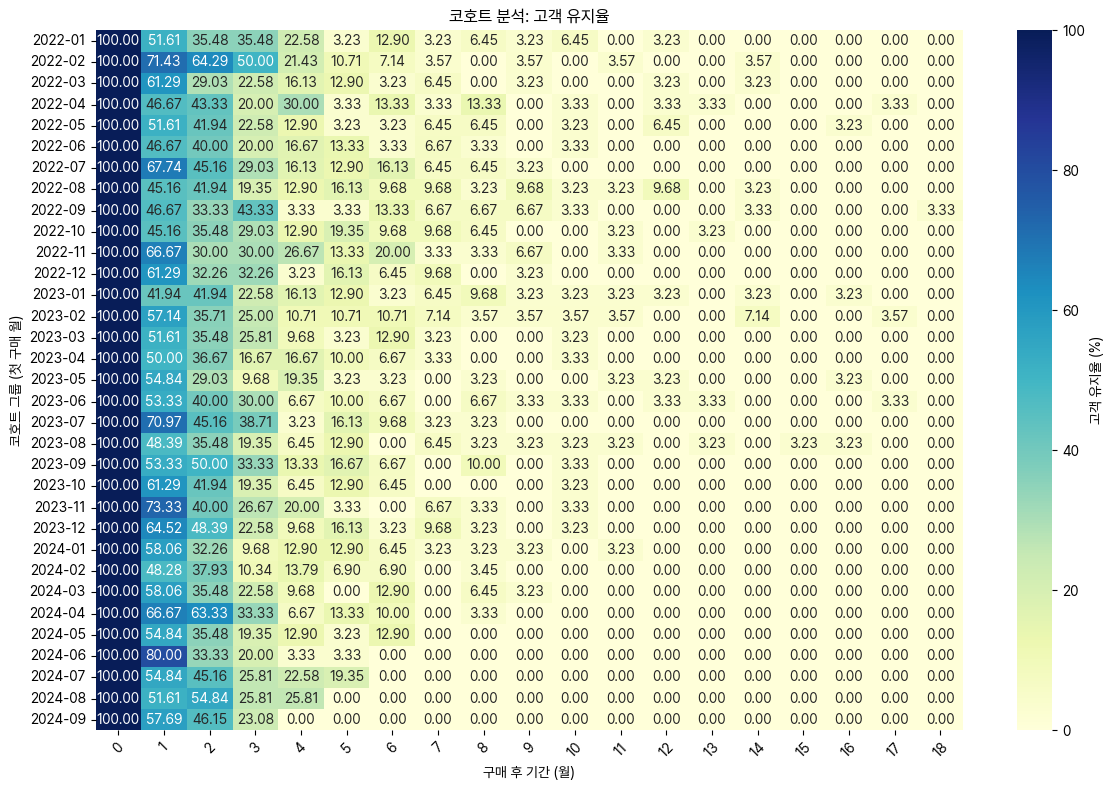

1개월 후 고객 유지율: 100.00%
3개월 후 고객 유지율: 40.48%
6개월 후 고객 유지율: 9.55%


In [147]:
# 코호트 분석
df

# 첫 구매 월 기준으로 코호트 생성
t_cohort = df.copy()
t_cohort['purchase_period'] = t_cohort['purchase_date'].dt.to_period('M')  # 월 단위로 변환

# 각 고객의 첫 구매 월 확인
first_purchase = t_cohort.groupby('customer_id')['purchase_date'].min().dt.to_period('M')
# t_cohort.groupby('customer_id')['purchase_period'].min()  # 이렇게 하면 안 되나?
first_purchase = first_purchase.reset_index()
first_purchase.columns = ['customer_id', 'cohort_group']

# first_purchase랑 t_cohort 합치기
t_cohort = t_cohort.merge(first_purchase, on='customer_id', how='inner')

# 첫 구매 이후 기간(월) 계산
# t_cohort['period_n'] = (t_cohort['purchase_period'].astype(int) - t_cohort['cohort_group'].astype(int))

# 개같은 MonthEnd를 제대로 처리해주기(attrgetter 활용)
from operator import attrgetter
t_cohort['period_n'] = (t_cohort['purchase_period'] - t_cohort['cohort_group']).apply(attrgetter('n'))

cohort_data = t_cohort.groupby(['cohort_group', 'period_n'])['customer_id'].nunique().fillna(0).reset_index()
# # 바로 윗줄을 피벗테이블화
# cohort_pivot = t_cohort.groupby(['cohort_group', 'period_n'])['customer_id'].nunique().unstack().fillna(0)
# # 바로 윗줄을 히트맵으로 시각화\
# plt.figure(figsize=(12, 8))
# sns.heatmap(cohort_pivot, annot=True, fmt='.0f', cmap='YlGnBu', cbar_kws={'label': '고객 수'})
# plt.title('코호트 분석: 고객 유지율')
# plt.xlabel('구매 후 기간 (월)')
# plt.ylabel('코호트 그룹 (첫 구매 월)')
# plt.xticks(rotation=45)
# plt.yticks(rotation=0)
# plt.tight_layout()
# plt.show()

cohort_size = first_purchase.groupby('cohort_group')['customer_id'].nunique()

# 각 그룹이 n개월 지났을 때, 총 구매횟수
cohort_table = cohort_data.pivot(
    index='cohort_group',
    columns='period_n',
    values='customer_id'
).fillna(0)

cohort_rate = (cohort_table.divide(cohort_size, axis=0) * 100).round(2)

cohort_rate
# 비율 그래프를 히트맵으로 시각화
plt.figure(figsize=(12, 8))
sns.heatmap(cohort_rate, annot=True, fmt='.2f', cmap='YlGnBu', cbar_kws={'label': '고객 유지율 (%)'})
plt.title('코호트 분석: 고객 유지율')
plt.xlabel('구매 후 기간 (월)')
plt.ylabel('코호트 그룹 (첫 구매 월)')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
# 코호트 분석 결과 해석
# 1, 3, 6개월 후 고객 유지율이 어떻게 변화하는지 출력
cohort_1_month = cohort_rate.iloc[:, 0].mean()
cohort_3_month = cohort_rate.iloc[:, 2].mean()
cohort_6_month = cohort_rate.iloc[:, 5].mean()
print(f'1개월 후 고객 유지율: {cohort_1_month:.2f}%')
print(f'3개월 후 고객 유지율: {cohort_3_month:.2f}%')
print(f'6개월 후 고객 유지율: {cohort_6_month:.2f}%')